In [1]:
! pip install cmake==3.18
! pip install pykeops
! pip install gpytorch

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings()    # perform the compilation

In [1]:
import gpytorch
import pykeops
print(gpytorch.__version__)
print(pykeops.__version__)

1.5.1
1.5


In [2]:
import sys
import os
import subprocess
import tarfile
import shutil
import types
import math
import pickle

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.autograd import grad
import gpytorch

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import boda
from boda.generator import plot_tools
from boda.common import constants
from boda.common.utils import unpack_artifact, model_fn

from scipy import spatial
from scipy.cluster import hierarchy
from scipy.stats import spearmanr
import urllib.request
from scipy.io import loadmat

lbfgs_src = '/'.join( os.getcwd().split('/')[ :os.getcwd().split('/').index('boda2') ]+['PyTorch-LBFGS/functions'] )
sys.path.insert(0, lbfgs_src)

from LBFGS import FullBatchLBFGS

In [3]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')

hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211112_154705__841131.tar.gz'

unpack_artifact(hpo_rec)

model_dir = './artifacts'

my_model = model_fn(model_dir)
my_model.cuda()
my_model.eval()

left_flank = boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_UPSTREAM[-200:] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {left_flank.shape}')

right_flank= boda.common.utils.dna2tensor( 
    boda.common.constants.MPRA_DOWNSTREAM[:200] 
).unsqueeze(0)
print(f'Left flanking sequence shape: {right_flank.shape}')

Loaded model from 20211112_154705 in eval mode
Left flanking sequence shape: torch.Size([1, 4, 200])
Left flanking sequence shape: torch.Size([1, 4, 200])


In [4]:
my_model

BassetBranched(
  (pad1): ConstantPad1d(padding=(9, 9), value=0.0)
  (conv1): Conv1dNorm(
    (conv): Conv1d(4, 300, kernel_size=(19,), stride=(1,))
    (bn_layer): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad2): ConstantPad1d(padding=(5, 5), value=0.0)
  (conv2): Conv1dNorm(
    (conv): Conv1d(300, 200, kernel_size=(11,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad3): ConstantPad1d(padding=(3, 3), value=0.0)
  (conv3): Conv1dNorm(
    (conv): Conv1d(200, 200, kernel_size=(7,), stride=(1,))
    (bn_layer): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pad4): ConstantPad1d(padding=(1, 1), value=0.0)
  (maxpool_3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (maxpool_4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (linear1): LinearNorm(
    (linear): Linear(in

In [5]:
class MyEnergy(torch.nn.Module):
    
    def __init__(self, model, left_flank, right_flank, bias_cell=None, bias_alpha=1.):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('left_flank', left_flank.to(model.device))
        self.register_buffer('right_flank', right_flank.to(model.device))
        
        self.bias_cell = bias_cell
        self.bias_alpha= bias_alpha
        
    def add_flanks(self, x):
        try:
            expand_left  = self.left_flank.expand(self.batch_size, -1, -1)
            expand_right = self.right_flank.expand(self.batch_size, -1, -1)
            return torch.cat([ expand_left, x, expand_right ], dim=-1)
        except (AttributeError, RuntimeError) as e:
            self.batch_size = x.shape[0]
            return self.add_flanks(x)
        
    def forward(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
                
        hook = self.model(hook)
        
        if self.bias_cell is not None:
            hook = hook[...,[ x for x in range(hook.shape[-1]) if x != self.bias_cell]].max(-1).values \
                     - hook[...,self.bias_cell].mul(self.bias_alpha)
        else:
            hook = boda.graph.utils.shannon_entropy(hook)

        return hook
    
    def encode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook
    
    def encode_and_decode(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        hook = self.model.encode(hook)
        
        return hook, self.model.decode(hook)
    
    def encode_and_decode_and_pred(self, x):
        hook = x.to(self.model.device)
        
        hook = self.add_flanks(hook)
        
        ec = self.model.encode(hook)
        
        dc = self.model.decode(ec)
        
        pre= self.model.classify(dc)
        
        return ec, dc, pre

In [6]:
my_energy = MyEnergy(my_model, left_flank, right_flank, bias_cell=None, bias_alpha=1.)

In [7]:
data_module = getattr(boda.data, 'MPRA_DataModule')
data = data_module(datafile_path='gs://syrgoth/data/MPRA_ALL_HD_v2.txt', data_project=['BODA'], padded_seq_len=600)
data.setup()

cell_type = 0

--------------------------------------------------

K562 | top cut value: 12.37, bottom cut value: -7.18
HepG2 | top cut value: 10.21, bottom cut value: -5.52
SKNSH | top cut value: 10.66, bottom cut value: -6.01

Number of examples discarded from top: 0
Number of examples discarded from bottom: 0

Number of examples available: 26914

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
--------------------------------------------------

Number of examples in train: 22246 (82.66%)
Number of examples in val:   2343 (8.71%)
Number of examples in test:  2325 (8.64%)

Excluded from train: 0 (0.0)%
--------------------------------------------------


In [8]:
print( len(data.chr_dataset_train) )
for batch in data.chr_dataset_train:
    x, y = batch
    print(x.shape)
    print(y.shape)
    break

10805
torch.Size([4, 600])
torch.Size([3])


In [9]:
def degeneracy_filter(in_tensor, max_degeneracy=1.):
    mode_check = in_tensor.cpu() == in_tensor.cpu().mode(dim=0).values
    return torch.tensor([ val < int(max_degeneracy*mode_check.shape[0]) for val in mode_check.sum(0) ])

In [10]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.dataset_train) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded, decoded, preds = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded)
        dec_.append(decoded)
        pre_.append(preds)
        
encoded = torch.cat(enc_, dim=0)
decoded = torch.cat(dec_, dim=0)
preds   = torch.cat(pre_, dim=0)

print(encoded.shape)
print(decoded.shape)
print(preds.shape)


torch.Size([22246, 4, 200])
torch.Size([22246])


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([22246, 2600])
torch.Size([22246, 435])
torch.Size([22246, 3])


Check encoder degeneracy.
proportion equal to mode


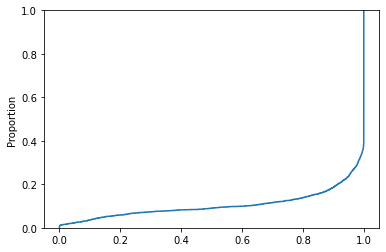

proportion different from mode


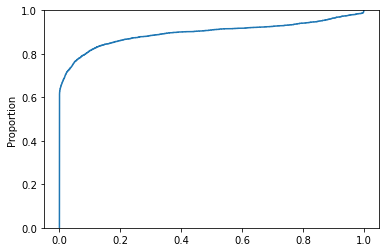

Check decoder degeneracy.
proportion equal to mode


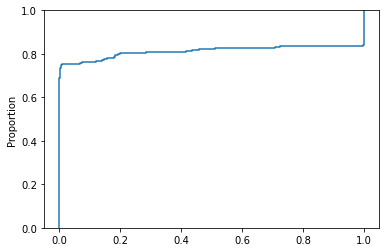

proportion different from mode


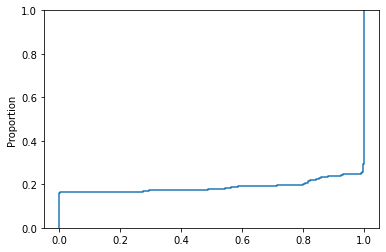

In [11]:
print("Check encoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = encoded.cpu() == encoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

print("Check decoder degeneracy.")

with torch.no_grad():
    p = []
    t = 0
    mode_check = decoded.cpu() == decoded.cpu().mode(dim=0).values
    for i, val in enumerate(mode_check.sum(0)):
        p.append( (val.item() / mode_check.shape[0]) )
    p = np.array(p)

print('proportion equal to mode')
sns.ecdfplot(p)
plt.show()
print('proportion different from mode')
sns.ecdfplot(1-p)
plt.show()

In [12]:
enc_filter = degeneracy_filter(encoded, 0.8)
print(f'encoder: {enc_filter.sum()} passed features')
dec_filter = degeneracy_filter(decoded, 0.8)
print(f'decoder: {dec_filter.sum()} passed features')

encoder: 361 passed features
decoder: 363 passed features


In [13]:
#train_x, train_y = decoded[:,dec_filter].cpu(), Y.cpu()
train_x, train_y = encoded[:,enc_filter].cpu(), Y.cpu()

mean_x, std_x = train_x.mean(dim=0, keepdim=True), train_x.std(dim=0, keepdim=True)
mean_y, std_y = train_y.mean(dim=0, keepdim=True), train_y.std(dim=0, keepdim=True)

train_x, train_y = (train_x - mean_x) / std_x, (train_y - mean_y) / std_y

In [14]:
X, Y = [ torch.stack(z, dim=0) for z in zip(*data.chr_dataset_test) ]
X = X[:, :, 200:400]
Y = Y[:,cell_type]
print(X.shape)
print(Y.shape)

bsz = 128

enc_ = []
dec_ = []
pre_ = []

with torch.no_grad():
    for i in range((X.shape[0]//bsz)+1):
        X_batch = X[i*bsz:(i+1)*bsz]
        encoded_test, decoded_test, preds_test = my_energy.encode_and_decode_and_pred(X_batch)
        
        enc_.append(encoded_test)
        dec_.append(decoded_test)
        pre_.append(preds_test)
        
encoded_test = torch.cat(enc_, dim=0)
decoded_test = torch.cat(dec_, dim=0)
preds_test   = torch.cat(pre_, dim=0)

    
print(encoded_test.shape)
print(decoded_test.shape)
print(preds_test.shape)

torch.Size([895, 4, 200])
torch.Size([895])
torch.Size([895, 2600])
torch.Size([895, 435])
torch.Size([895, 3])


In [15]:
#test_x, test_y = decoded_test[:,dec_filter].cpu(), Y.cpu()
test_x, test_y = encoded_test[:,enc_filter].cpu(), Y.cpu()

test_x = (test_x - mean_x) / std_x
test_y = (test_y - mean_y) / std_y

In [16]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.keops.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train(train_x,
          train_y,
          n_training_iter=50
         ):
    
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    model = ExactGPModel(train_x, train_y, likelihood).cuda()
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    pbar = tqdm(range(n_training_iter), desc='Steps', position=0, leave=True)
    for i in pbar:
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        '''
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, n_training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
        '''
        pbar.set_postfix(
            {'Loss': loss.item(),
             'lengthscale': model.covar_module.base_kernel.lengthscale.item(),
             'noise':model.likelihood.noise.item()}            
        )
        optimizer.step()
    print(f"Finished training on {train_x.size(0)} data points using KeOps.")
    return model, likelihood

In [17]:
model, likelihood = train(train_x.cuda(), train_y.cuda(),
                          n_training_iter=50)

Steps:   0%|          | 0/50 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
Steps: 100%|██████████| 50/50 [00:09<00:00,  5.30it/s, Loss=1.42, lengthscale=0.693, noise=0.493]

Finished training on 22246 data points using KeOps.


In [21]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(train_x[-20:].cuda()))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [19]:
test_x[-20:]

tensor([[-0.4276, -1.5736,  2.0052,  ...,  0.2347,  0.4552,  1.8921],
        [ 0.0000, -1.5736,  0.6684,  ...,  1.5836, -0.6103,  0.5819],
        [ 0.0000, -0.7868,  0.6684,  ..., -0.4747,  0.5871,  2.1790],
        ...,
        [ 0.0000, -2.3604,  2.6736,  ..., -0.4747, -0.6103, -0.1574],
        [ 1.2829,  0.0000,  2.6736,  ...,  1.6057,  2.4179,  3.5267],
        [ 0.8553, -1.5736,  3.3420,  ..., -0.4747, -0.6103, -0.9021]])

In [22]:
observed_pred.mean

tensor([ 0.0190, -0.0716, -0.1216, -0.4455, -0.1401,  1.2966, -0.1723, -0.2490,
        -0.4499,  0.3029, -0.3292, -0.5254, -0.5294,  0.3875,  0.0058, -0.3120,
         1.7113,  1.0028, -0.3253,  0.0073], device='cuda:0')

In [25]:
train_y[:20]

tensor([ 0.1717,  0.7507,  0.3270, -0.5722, -0.5641, -0.6813, -0.5987,  0.8834,
        -0.1881, -0.1996,  1.7170,  3.2295, -1.0331,  0.7031,  4.5174, -0.8927,
        -0.3633, -0.3895, -0.6529, -0.7624])

In [20]:
test_x.shape

torch.Size([895, 361])

In [21]:
train_x.shape

torch.Size([22246, 361])

In [34]:
(test_x.std(0) - 1.).abs().max()

tensor(0.4498)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x.cuda()))
    mean = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [27]:
train_x

tensor([[ 0.0000, -1.5736,  1.6710,  ..., -0.4747,  1.3731,  0.7145],
        [ 0.8553, -1.5736,  2.6736,  ..., -0.4747, -0.6103, -0.9021],
        [ 1.2829, -2.3604,  2.6736,  ..., -0.4747, -0.6103, -0.9021],
        ...,
        [ 0.0000, -3.1472,  0.3342,  ..., -0.4747, -0.6103, -0.1531],
        [ 1.2829, -2.3604,  1.0026,  ...,  2.2724, -0.3209, -0.9021],
        [ 1.7105, -0.7868,  2.0052,  ..., -0.4747, -0.6103, -0.8996]])

In [29]:
std_x

tensor([1.7423e-08, 1.8939e-08, 2.2294e-08, 1.6505e-02, 3.2741e-02, 5.5115e-02,
        5.6407e-02, 5.4893e-02, 4.2193e-02, 6.8722e-04, 2.1652e-08, 1.8860e-08,
        1.6473e-08, 1.5007e-08, 1.9273e-08, 2.3185e-08, 3.7794e-04, 3.3152e-02,
        3.9943e-02, 4.0240e-02, 3.9958e-02, 3.2653e-02, 3.5954e-03, 1.6563e-08,
        1.3618e-08, 1.1293e-08, 2.8801e-02, 1.1438e-08, 1.9045e-02, 2.7922e-02,
        2.8316e-02, 2.8573e-02, 2.9179e-02, 8.5483e-03, 9.7185e-09, 1.0293e-02,
        2.0990e-02, 1.9562e-02, 1.8268e-02, 1.7899e-02, 1.5528e-02, 6.7196e-03,
        2.9699e-02, 3.6200e-02, 2.8557e-02, 3.2780e-02, 2.8615e-02, 2.1683e-02,
        2.3044e-02, 2.3145e-02, 1.5920e-02, 2.6491e-02, 3.8363e-02, 4.5028e-02,
        2.3826e-02, 3.7066e-02, 4.0393e-02, 3.9561e-02, 1.4830e-02, 2.6032e-02,
        3.4078e-02, 3.6025e-02, 3.6868e-02, 3.6076e-02, 1.3414e-02, 2.4687e-02,
        3.1030e-02, 4.5957e-02, 5.1689e-02, 4.9607e-02, 4.6034e-02, 2.2847e-02,
        2.3334e-08, 1.9353e-02, 1.8260e-

# Plot results

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


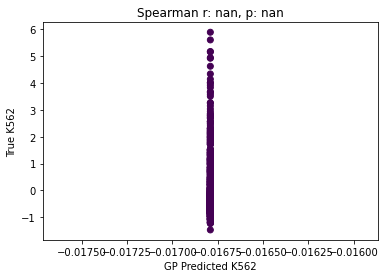

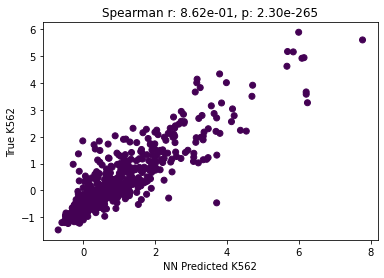

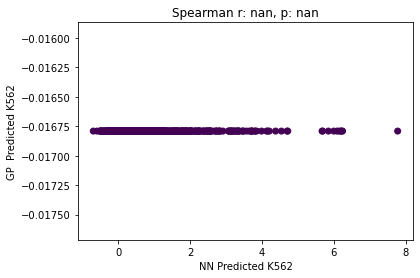

In [18]:
plt.scatter( mean.cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( mean.cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), test_y.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), Y.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("True K562")
plt.show()

plt.scatter( preds_test[:,0].cpu().numpy(), mean.cpu().numpy(), c=(upper-lower).cpu().numpy(), cmap='viridis' )
corr, pval = spearmanr( preds_test[:,0].cpu().numpy(), mean.cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Predicted K562")
plt.ylabel("GP  Predicted K562")
plt.show()

In [25]:
from sklearn.decomposition import PCA

dim_red = PCA(n_components = 3)

seq_pca = dim_red.fit_transform(encoded.cpu().numpy())
seq_pca_test = dim_red.transform(encoded_test.cpu().numpy())

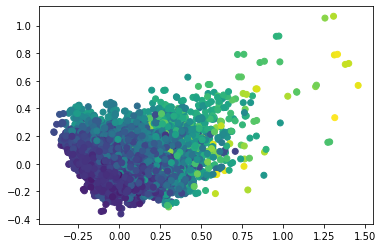

In [26]:
plt.scatter( seq_pca_test[:,0], seq_pca_test[:,1], c=Y.cpu().numpy(), cmap='viridis' )
plt.show()

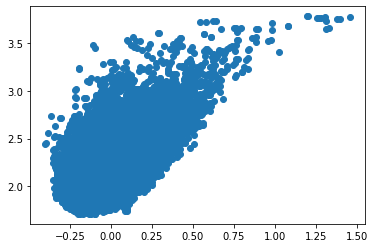

In [27]:
plt.scatter( seq_pca_test[:,0], (upper-lower).cpu().numpy() )
plt.show()

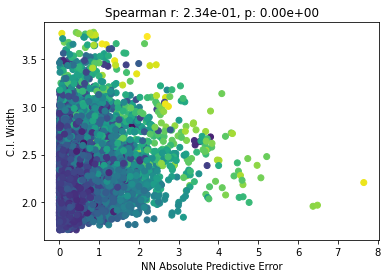

In [28]:
plt.scatter( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )
corr, pval = spearmanr( (preds_test[:,0].cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("NN Absolute Predictive Error")
plt.ylabel("C.I. Width")
plt.show()

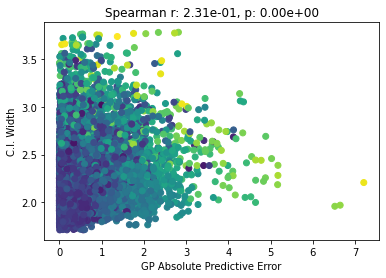

In [29]:
plt.scatter( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy(), c=Y.cpu(), cmap='viridis' )

corr, pval = spearmanr( (mean.cpu()-Y.cpu()).abs().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Absolute Predictive Error")
plt.ylabel("C.I. Width")

plt.show()

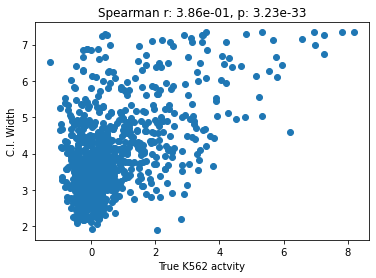

In [21]:
plt.scatter( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( Y.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("True K562 actvity")
plt.ylabel("C.I. Width")
plt.show()

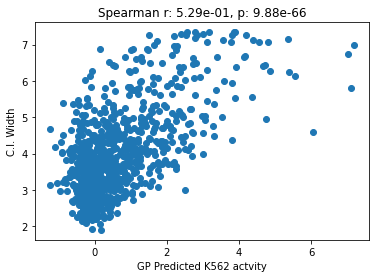

In [22]:
plt.scatter( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
corr, pval = spearmanr( mean.cpu().numpy(), (upper-lower).cpu().numpy() )
plt.title("Spearman r: {:.2e}, p: {:.2e}".format(corr,pval))
plt.xlabel("GP Predicted K562 actvity")
plt.ylabel("C.I. Width")
plt.show()